In [8]:
# ===============================
# 1. Install Dependencies
# ===============================
# pip install ccxt pandas pandas_ta torch scikit-learn

import ccxt
import pandas as pd
import pandas_ta as ta
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

/home/gregory/Trading_bot/venv/lib/python3.12/site-packages/pandas_ta/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [17]:
# ===============================
# 2. Fetch Data from Binance
# ===============================
exchange = ccxt.binance()
symbol = "BTC/USDT"
timeframe = "1h"
limit = 10000  # max per request

ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)

df = pd.DataFrame(ohlcv, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Date'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('Date', inplace=True)
df.drop(columns=['timestamp'], inplace=True)


In [18]:
# ===============================
# 3. Feature Engineering (Indicators)
# ===============================
df["rsi"] = ta.rsi(df["Close"], length=14)
df["ema20"] = ta.ema(df["Close"], length=20)
df["ema50"] = ta.ema(df["Close"], length=50)
df["macd"] = ta.macd(df["Close"], fast=12, slow=26, signal=9)["MACD_12_26_9"]
df["stoch"] = ta.stoch(df["High"], df["Low"], df["Close"])["STOCHk_14_3_3"]
df["atr"] = ta.atr(df["High"], df["Low"], df["Close"], length=14)

df.dropna(inplace=True)


In [19]:
# ===============================
# 4. Label: Next Candle Bullish/Bearish
# ===============================
df["label"] = (df["Close"].shift(-1) > df["Close"]).astype(int)  # 1 = bullish, 0 = bearish
df.dropna(inplace=True)

features = ["Close", "Volume", "rsi", "ema20", "ema50", "macd", "stoch", "atr"]
X = df[features].values
y = df["label"].values

In [20]:
# ===============================
# 5. Normalize & Prepare Sequences
# ===============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

SEQ_LEN = 50  # sequence length
def create_sequences(data, labels, seq_len=SEQ_LEN):
    Xs, ys = [], []
    for i in range(len(data) - seq_len):
        Xs.append(data[i:i+seq_len])
        ys.append(labels[i+seq_len])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y, SEQ_LEN)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [23]:
# ===============================
# 6. Define LSTM Model
# ===============================
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last hidden state
        out = self.fc(out)
        return out

input_size = len(features)
hidden_size = 100
num_layers = 4
output_size = 2  # bullish or bearish

model = LSTMModel(input_size, hidden_size, num_layers, output_size)


In [24]:
# ===============================
# 7. Train Model
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 1000
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    # Accuracy
    _, predicted = torch.max(output, 1)
    acc = (predicted == y_train).float().mean()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}, Train Acc: {acc.item():.4f}")


Epoch 1/1000, Loss: 0.6951, Train Acc: 0.5056
Epoch 2/1000, Loss: 0.6937, Train Acc: 0.5056
Epoch 3/1000, Loss: 0.6931, Train Acc: 0.5056
Epoch 4/1000, Loss: 0.6931, Train Acc: 0.4944
Epoch 5/1000, Loss: 0.6933, Train Acc: 0.4944
Epoch 6/1000, Loss: 0.6932, Train Acc: 0.4944
Epoch 7/1000, Loss: 0.6930, Train Acc: 0.4944
Epoch 8/1000, Loss: 0.6927, Train Acc: 0.5264
Epoch 9/1000, Loss: 0.6926, Train Acc: 0.5347
Epoch 10/1000, Loss: 0.6925, Train Acc: 0.5153
Epoch 11/1000, Loss: 0.6923, Train Acc: 0.5097
Epoch 12/1000, Loss: 0.6922, Train Acc: 0.5139
Epoch 13/1000, Loss: 0.6919, Train Acc: 0.5194
Epoch 14/1000, Loss: 0.6915, Train Acc: 0.5250
Epoch 15/1000, Loss: 0.6909, Train Acc: 0.5347
Epoch 16/1000, Loss: 0.6904, Train Acc: 0.5472
Epoch 17/1000, Loss: 0.6901, Train Acc: 0.5250
Epoch 18/1000, Loss: 0.6896, Train Acc: 0.5500
Epoch 19/1000, Loss: 0.6889, Train Acc: 0.5528
Epoch 20/1000, Loss: 0.6881, Train Acc: 0.5417
Epoch 21/1000, Loss: 0.6876, Train Acc: 0.5472
Epoch 22/1000, Loss: 0

In [25]:
# ===============================
# 8. Evaluate
# ===============================
model.eval()
with torch.no_grad():
    output = model(X_test)
    _, predicted = torch.max(output, 1)
    acc = (predicted == y_test).float().mean()
    print(f"Test Accuracy: {acc.item():.4f}")

Test Accuracy: 0.4862


/tmp/ipykernel_7595/1471412365.py:49: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_test['signal'].iloc[0] = np.nan  # no action at the first test row
/tmp/ipykernel_7595/1471412365.py:49: SettingWithCopyWarning: 
A value is trying to be 

===== Backtest Summary =====
Initial balance: $1,000.00
Final balance:   $1,007.10
Net profit:      $7.10 (0.71%)
Total trades:    86
Wins: 39, Losses: 141
Avg win: $2.05, Avg loss: $-0.52


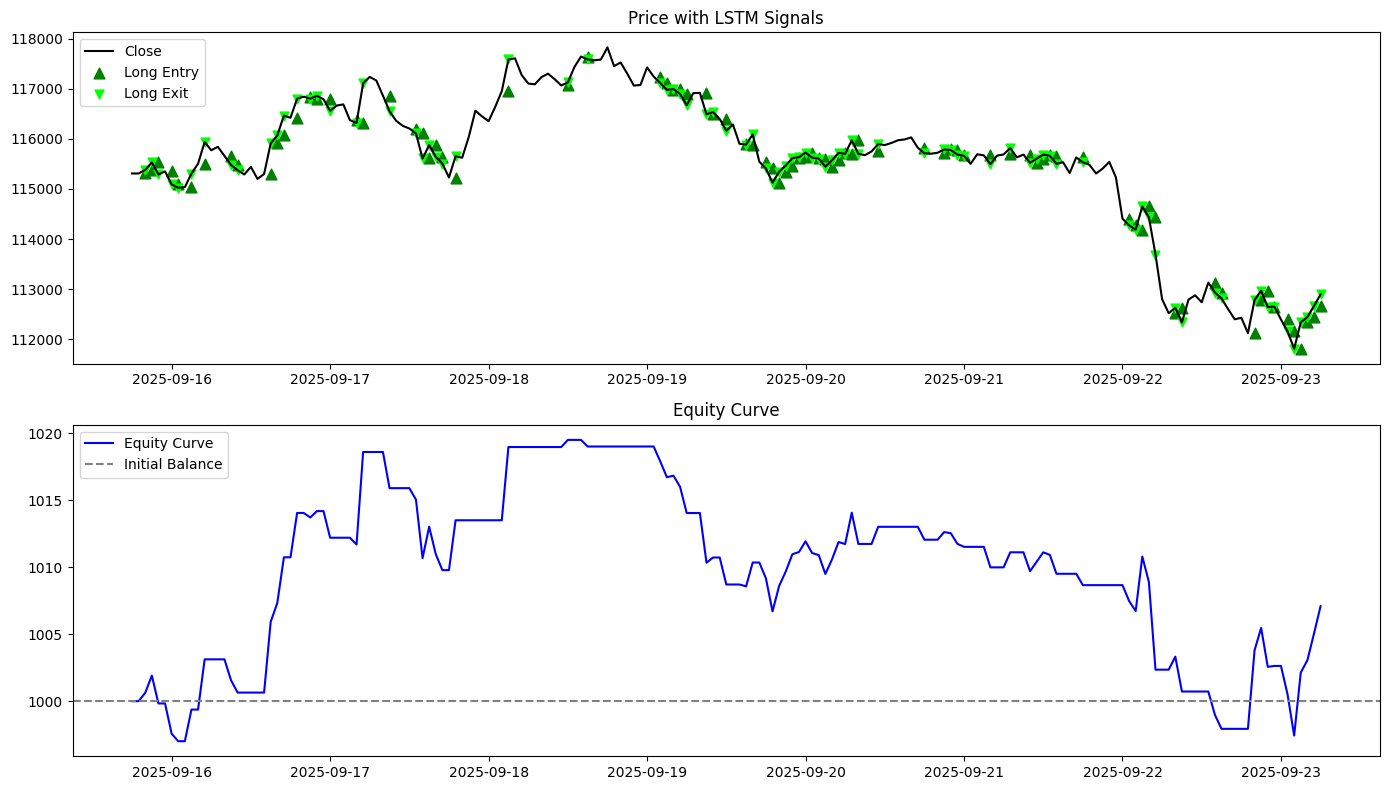

In [29]:
# ---------- Robust Backtest & Visualization ----------
import numpy as np
import torch
import matplotlib.pyplot as plt

# Controls
initial_balance = 1000.0
allow_shorts = False   # True if you want to allow short trades
fee_pct = 0.0          # e.g. 0.001 for 0.1% per trade (optional)
slippage_pct = 0.0     # e.g. 0.001 for 0.1% slippage (optional)

# 1) Get predictions for X_test (ensure model, X_test exist)
model.eval()
with torch.no_grad():
    logits = model(X_test)                     # torch tensor [n_test, 2]
    _, predicted = torch.max(logits, dim=1)    # predicted class indices (0/1)
predicted = predicted.cpu().numpy()
n_test = len(predicted)

# 2) Compute starting index in df for the first test sequence
# Each sequence i corresponds to df row index i + SEQ_LEN
# Test sequences start at index = n_train (number of sequences used for training)
# Try several ways to obtain n_train robustly:
try:
    n_train = X_train.shape[0]
except NameError:
    try:
        n_train = len(X_seq) - len(X_test)  # fallback if X_seq exists
    except NameError:
        # Last resort: assume 80% split (dangerous) — but try to infer
        raise NameError("Couldn't infer train split. Ensure X_train or X_seq is defined.")

start_idx = SEQ_LEN + n_train
end_idx = start_idx + n_test
df_test = df.iloc[start_idx:end_idx].copy()

# Safety check
if len(df_test) != n_test:
    # Try to recover: if off by one because of an extra / missing row, align by min length
    min_len = min(len(df_test), n_test)
    df_test = df_test.iloc[:min_len].copy()
    predicted = predicted[:min_len]
    n_test = min_len
    print(f"Warning: trimmed to min length {min_len} to align predictions and df rows.")

# 3) Attach predictions and shift to form actionable signal (act on previous prediction)
df_test['prediction'] = predicted
df_test['signal'] = df_test['prediction'].shift(1)  # we act on the previous prediction
df_test['signal'].iloc[0] = np.nan  # no action at the first test row

# 4) Backtest loop: buy at previous close, sell at current close
balance = float(initial_balance)
equity_curve = []
trade_records = []

for i in range(len(df_test)):
    # At row i we compute equity after applying the signal decided at i (which was prediction at i-1)
    if i == 0:
        equity_curve.append(balance)  # no trade on first row
        continue

    signal = df_test['signal'].iat[i]
    price_prev = float(df_test['Close'].iat[i-1])
    price_now  = float(df_test['Close'].iat[i])

    # If no valid signal -> hold
    if np.isnan(signal):
        equity_curve.append(balance)
        continue

    # Skip if invalid prices
    if price_prev <= 0 or price_now <= 0:
        equity_curve.append(balance)
        continue

    # Apply slippage and fees (approximate)
    # buy_price = price_prev * (1 + slippage_pct)
    # sell_price = price_now * (1 - slippage_pct)
    # We'll apply slippage symmetrically to expected pnl
    if int(signal) == 1:
        # LONG: buy at prev close, sell at current close
        gross_return = (price_now - price_prev) / price_prev
        pnl = balance * gross_return
        # fees approximate: apply on roundtrip
        roundtrip_fee = fee_pct * balance * 2
        # slippage approximate cost:
        slippage_cost = abs(gross_return) * slippage_pct * balance
        balance += pnl - roundtrip_fee - slippage_cost
        trade_records.append({'time': df_test.index[i], 'type': 'LONG', 'entry': price_prev, 'exit': price_now, 'pnl': pnl - roundtrip_fee - slippage_cost})
    else:
        # BEARISH signal
        if allow_shorts:
            gross_return = (price_prev - price_now) / price_prev
            pnl = balance * gross_return
            roundtrip_fee = fee_pct * balance * 2
            slippage_cost = abs(gross_return) * slippage_pct * balance
            balance += pnl - roundtrip_fee - slippage_cost
            trade_records.append({'time': df_test.index[i], 'type': 'SHORT', 'entry': price_prev, 'exit': price_now, 'pnl': pnl - roundtrip_fee - slippage_cost})
        else:
            # long-only: do nothing on bearish
            trade_records.append({'time': df_test.index[i], 'type': 'HOLD', 'entry': price_prev, 'exit': price_now, 'pnl': 0.0})

    equity_curve.append(balance)

# Ensure equity_curve aligned with df_test
if len(equity_curve) < len(df_test):
    equity_curve = [initial_balance] * (len(df_test) - len(equity_curve)) + equity_curve  # pad at front if needed
elif len(equity_curve) > len(df_test):
    equity_curve = equity_curve[-len(df_test):]  # trim if necessary

df_test['equity'] = equity_curve

# 5) Summary stats
final_balance = balance
net_profit = final_balance - initial_balance
roi_pct = (net_profit / initial_balance) * 100
num_trades = sum(1 for t in trade_records if t['type'] in ('LONG','SHORT'))
wins = sum(1 for t in trade_records if t['pnl'] > 0)
losses = sum(1 for t in trade_records if t['pnl'] <= 0)
avg_win = np.mean([t['pnl'] for t in trade_records if t['pnl'] > 0]) if wins>0 else 0
avg_loss = np.mean([t['pnl'] for t in trade_records if t['pnl'] <= 0]) if losses>0 else 0

print("===== Backtest Summary =====")
print(f"Initial balance: ${initial_balance:,.2f}")
print(f"Final balance:   ${final_balance:,.2f}")
print(f"Net profit:      ${net_profit:,.2f} ({roi_pct:.2f}%)")
print(f"Total trades:    {num_trades}")
print(f"Wins: {wins}, Losses: {losses}")
print(f"Avg win: ${avg_win:.2f}, Avg loss: ${avg_loss:.2f}")

# 6) Visualization
plt.figure(figsize=(14,8))

ax1 = plt.subplot(2,1,1)
ax1.plot(df_test.index, df_test['Close'], label='Close', color='black')
longs = [t for t in trade_records if t['type']=='LONG']
shorts = [t for t in trade_records if t['type']=='SHORT']
if longs:
    ax1.scatter([t['time'] for t in longs], [t['entry'] for t in longs], marker='^', color='green', s=60, label='Long Entry')
    ax1.scatter([t['time'] for t in longs], [t['exit'] for t in longs], marker='v', color='lime', s=40, label='Long Exit')
if allow_shorts and shorts:
    ax1.scatter([t['time'] for t in shorts], [t['entry'] for t in shorts], marker='v', color='red', s=60, label='Short Entry')
    ax1.scatter([t['time'] for t in shorts], [t['exit'] for t in shorts], marker='^', color='orange', s=40, label='Short Exit')
ax1.set_title('Price with LSTM Signals')
ax1.legend(loc='upper left')

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(df_test.index, df_test['equity'], label='Equity Curve', color='blue')
ax2.axhline(initial_balance, color='gray', linestyle='--', label='Initial Balance')
ax2.set_title('Equity Curve')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()
